# JaX Flax --> ONNX

This notebook converts brax MLP networks to an ONNX checkpoint.

In [1]:
ckpt_path = "/home/xinchen/Dev/philab-mujoco/logs/TronPfJoystick-20250725-053551"
env_name = "TronPfJoystick"

# ckpt_path = "/home/xinchen/Dev/philab-mujoco/logs/TronSfJoystick-20250722-055050"
# env_name = "TronSfJoystick"

In [2]:
import os

os.environ["JAX_DEFAULT_MATMUL_PRECISION"] = "high"
os.environ["PYGLFW_LIBRARY_VARIANT"] = "x11"


In [3]:
from brax.training.agents.ppo import networks as ppo_networks
from philab_mujoco import locomotion
from philab_mujoco import train_params
import functools
import pickle
import jax.numpy as jp
import jax
import tf2onnx
import tensorflow as tf
from keras import layers
import onnxruntime as rt
from brax.training.acme import running_statistics

2025-07-25 07:14:14.727598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753445654.735742  161752 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753445654.738126  161752 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753445654.744274  161752 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753445654.744286  161752 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753445654.744287  161752 computation_placer.cc:177] computation placer alr

In [4]:
tf.config.set_visible_devices([], 'GPU')

W0000 00:00:1753445656.430871  161752 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [5]:
# ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params = train_params.brax_ppo_config(env_name)

In [6]:
def identity_observation_preprocessor(observation, preprocessor_params):
  del preprocessor_params
  return observation

network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

In [7]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)

In [8]:
obs_size = env.observation_size
act_size = env.action_size
# print(obs_size, act_size)

print(f"Observation size: {obs_size}")
print(f"Action size: {act_size}")

Observation size: {'privileged_state': (76,), 'state': (31,), 'state_history': (310,)}
Action size: 6


In [9]:
ppo_network = network_factory(obs_size, act_size)

In [10]:
ckpt_path = ckpt_path + "/params.pkl"

with open(ckpt_path, 'rb') as f:
    params = pickle.load(f)
print(params.keys())

# Save ONNX to the checkpoint directory
output_path = os.path.join(os.path.dirname(ckpt_path), "policy.onnx")

dict_keys(['normalizer_params', 'policy_params', 'value_params'])


In [11]:
params = (params["normalizer_params"], params["policy_params"])

In [12]:
make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params, deterministic=True)

In [13]:
class EMLP(tf.keras.Model):
    def __init__(
        self,
        encoder_layer_sizes,
        policy_layer_sizes,
        activation=tf.nn.relu,
        kernel_init="lecun_uniform",
        activate_final=False,
        bias=True,
        layer_norm=False,
        mean_std=None,
        encoder_mean_std=None,
    ):
        super().__init__()

        self.encoder_layer_sizes = encoder_layer_sizes
        self.policy_layer_sizes = policy_layer_sizes
        self.activation = activation
        self.kernel_init = kernel_init
        self.activate_final = activate_final
        self.bias = bias
        self.layer_norm = layer_norm

        # Main observation normalization
        if mean_std is not None:
            self.mean = tf.Variable(mean_std[0], trainable=False, dtype=tf.float32)
            self.std = tf.Variable(mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.mean = None
            self.std = None

        # Encoder observation normalization  
        if encoder_mean_std is not None:
            self.encoder_mean = tf.Variable(encoder_mean_std[0], trainable=False, dtype=tf.float32)
            self.encoder_std = tf.Variable(encoder_mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.encoder_mean = None
            self.encoder_std = None

        # Build encoder MLP (MLP_0 in JAX)
        self.encoder_block = tf.keras.Sequential(name="MLP_0")
        for i, size in enumerate(self.encoder_layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,  # Apply activation to all encoder layers
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.encoder_block.add(dense_layer)
            if self.layer_norm:
                self.encoder_block.add(layers.LayerNormalization(name=f"encoder_layer_norm_{i}"))

        # Build policy MLP (MLP_1 in JAX)
        self.policy_block = tf.keras.Sequential(name="MLP_1")
        for i, size in enumerate(self.policy_layer_sizes):
            # Apply activation except to final layer if activate_final=False
            if i == len(self.policy_layer_sizes) - 1 and not self.activate_final:
                activation_fn = None
            else:
                activation_fn = self.activation
                
            dense_layer = layers.Dense(
                size,
                activation=activation_fn,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.policy_block.add(dense_layer)
            if self.layer_norm:
                self.policy_block.add(layers.LayerNormalization(name=f"policy_layer_norm_{i}"))

        self.submodules = [self.encoder_block, self.policy_block]

    def call(self, inputs):
        if isinstance(inputs, list):
            if len(inputs) == 2:
                main_obs, encoder_obs = inputs
            else:
                main_obs = inputs[0]
                encoder_obs = None
        else:
            main_obs = inputs
            encoder_obs = None
        
        # Normalize main observation
        if self.mean is not None and self.std is not None:
            main_obs = (main_obs - self.mean) / self.std
        
        # Normalize and encode state_history
        if encoder_obs is not None and self.encoder_mean is not None and self.encoder_std is not None:
            encoder_obs = (encoder_obs - self.encoder_mean) / self.encoder_std
            encoded_features = self.encoder_block(encoder_obs)
            
            # Concatenate main_obs with encoded features
            combined_input = tf.concat([main_obs, encoded_features], axis=-1)
        else:
            combined_input = main_obs
        
        # Pass through policy MLP
        logits = self.policy_block(combined_input)
        loc, _ = tf.split(logits, 2, axis=-1)
        return tf.tanh(loc)

def make_policy_network(
    param_size,
    mean_std,
    encoder_mean_std,
    encoder_layer_sizes,
    policy_layer_sizes,
    activation=tf.nn.relu,
    kernel_init="lecun_uniform",
    layer_norm=False,
):
    # Convert to list and add param_size
    policy_sizes = list(policy_layer_sizes) + [param_size]
    
    policy_network = EMLP(
        encoder_layer_sizes=encoder_layer_sizes,
        policy_layer_sizes=policy_sizes,
        activation=activation,
        kernel_init=kernel_init,
        activate_final=False,
        layer_norm=layer_norm,
        mean_std=mean_std,
        encoder_mean_std=encoder_mean_std,
    )
    return policy_network

In [14]:
# Configure EMLP network parameters
encoder_obs_key = getattr(ppo_params.network_factory, 'encoder_obs_key', 'state_history')

# Get normalization parameters for both observations
main_mean = params[0].mean["state"]
main_std = params[0].std["state"]
main_mean_std = (tf.convert_to_tensor(main_mean), tf.convert_to_tensor(main_std))

encoder_mean = params[0].mean[encoder_obs_key]
encoder_std = params[0].std[encoder_obs_key]
encoder_mean_std = (tf.convert_to_tensor(encoder_mean), tf.convert_to_tensor(encoder_std))

# Network architecture: MLP_0 (encoder) + MLP_1 (policy)
encoder_layer_sizes = (128, 64, 16)  # MLP_0 sizes  
policy_layer_sizes = (512, 256, 128)  # MLP_1 sizes (excluding final layer)

tf_policy_network = make_policy_network(
    param_size=act_size * 2,
    mean_std=main_mean_std,
    encoder_mean_std=encoder_mean_std,
    encoder_layer_sizes=encoder_layer_sizes,
    policy_layer_sizes=policy_layer_sizes,
    activation=tf.nn.swish,
)

In [15]:
# Create EMLP test inputs
encoder_obs_key = getattr(ppo_params.network_factory, 'encoder_obs_key', 'state_history')
encoder_obs_size = obs_size[encoder_obs_key][0]

main_obs_input = tf.zeros((1, obs_size["state"][0]))
encoder_obs_input = tf.zeros((1, encoder_obs_size))

example_input = [main_obs_input, encoder_obs_input]
example_output = tf_policy_network(example_input)

print(f"EMLP output shape: {example_output.shape}")
print(f"Input sizes - Main obs: {obs_size['state'][0]}, Encoder obs: {encoder_obs_size}")

EMLP output shape: (1, 6)
Input sizes - Main obs: 31, Encoder obs: 310


In [16]:
import numpy as np
import tensorflow as tf

def transfer_weights(jax_params, tf_model):
    """Transfer weights from JAX EMLP (MLP_0 + MLP_1) to TensorFlow EMLP."""
    
    # Transfer MLP_0 (encoder) weights
    if 'MLP_0' in jax_params:
        mlp0_params = jax_params['MLP_0']
        for layer_name, layer_params in mlp0_params.items():
            tf_layer = tf_model.get_layer("MLP_0").get_layer(name=layer_name)
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            tf_layer.set_weights([kernel, bias])
    
    # Transfer MLP_1 (policy) weights
    if 'MLP_1' in jax_params:
        mlp1_params = jax_params['MLP_1']
        for layer_name, layer_params in mlp1_params.items():
            tf_layer = tf_model.get_layer("MLP_1").get_layer(name=layer_name)
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            tf_layer.set_weights([kernel, bias])

    print("EMLP weights transferred successfully.")

In [17]:
# Transfer weights from JAX to TensorFlow model
transfer_weights(params[1]['params'], tf_policy_network)

EMLP weights transferred successfully.


In [18]:
# Create test inputs and export to ONNX
encoder_obs_key = getattr(ppo_params.network_factory, 'encoder_obs_key', 'state_history')
encoder_obs_size = obs_size[encoder_obs_key][0]

# Test with specific values
main_obs_test = np.ones((1, obs_size["state"][0]), dtype=np.float32)
encoder_obs_test = np.ones((1, encoder_obs_size), dtype=np.float32)

test_input = [main_obs_test, encoder_obs_test]
tensorflow_pred = tf_policy_network(test_input)[0]
print(f"TensorFlow prediction: {tensorflow_pred}")

# Define input signature for ONNX export
spec = [
    tf.TensorSpec(shape=(1, obs_size["state"][0]), dtype=tf.float32, name="obs"),
    tf.TensorSpec(shape=(1, encoder_obs_size), dtype=tf.float32, name="obs_history")
]

tf_policy_network.output_names = ['action']

# Export to ONNX
model_proto, _ = tf2onnx.convert.from_keras(tf_policy_network, input_signature=spec, opset=11, output_path=output_path)

TensorFlow prediction: [ 0.27703953  0.0326834   0.42464632 -0.16951813 -0.27895322  0.32647243]


I0000 00:00:1753445658.754604  161752 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753445658.754721  161752 single_machine.cc:374] Starting new session
W0000 00:00:1753445658.757322  161752 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1753445658.762436  161752 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 98 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0
I0000 00:00:1753445658.834099  161752 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753445658.834217  161752 single_machine.cc:374] Starting new session
W0000 00:00:1753445658.837038  161752 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible

In [19]:
# Test ONNX Runtime inference
output_names = ['action']
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

onnx_input = {
    'obs': main_obs_test,
    'obs_history': encoder_obs_test
}

onnx_pred = m.run(output_names, onnx_input)[0][0]
print("ONNX prediction:", onnx_pred)

# Verify TensorFlow vs ONNX match
print(f"TensorFlow vs ONNX difference: {np.abs(tensorflow_pred - onnx_pred).max():.2e}")

ONNX prediction: [ 0.27703884  0.03268318  0.42464593 -0.16951776 -0.27895248  0.32647192]
TensorFlow vs ONNX difference: 7.45e-07


In [20]:
# Verify JAX vs TensorFlow/ONNX predictions match
encoder_obs_key = getattr(ppo_params.network_factory, 'encoder_obs_key', 'state_history')

test_input = {
    'state': jp.array(main_obs_test[0]),
    'privileged_state': jp.zeros(obs_size["privileged_state"]),
    encoder_obs_key: jp.array(encoder_obs_test[0])
}

jax_pred, _ = inference_fn(test_input, jax.random.PRNGKey(0))
print(f"JAX prediction: {jax_pred}")

# Compare all predictions
print(f"\n=== Final Verification ===")
print(f"JAX vs TensorFlow difference: {np.abs(jax_pred - tensorflow_pred).max():.2e}")
print(f"JAX vs ONNX difference: {np.abs(jax_pred - onnx_pred).max():.2e}")

if np.abs(jax_pred - tensorflow_pred).max() < 1e-5:
    print("✅ EMLP export successful - predictions match!")

JAX prediction: [ 0.27703908  0.0326834   0.42464608 -0.16951795 -0.27895278  0.32647213]

=== Final Verification ===
JAX vs TensorFlow difference: 4.47e-07
JAX vs ONNX difference: 2.98e-07
✅ EMLP export successful - predictions match!


Output shapes:
  ONNX: (6,)
  TensorFlow: (6,)
  JAX: (6,)


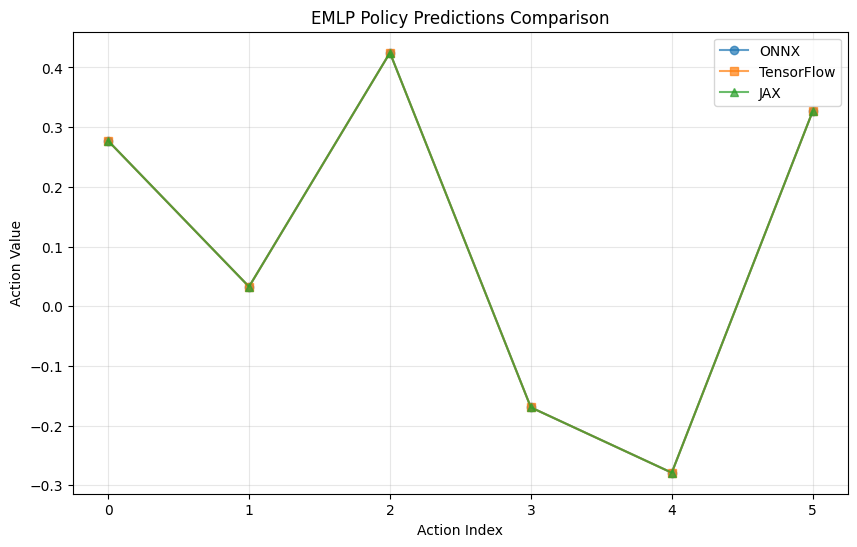


Numerical comparison:
Action 0: JAX=0.277039, TF=0.277040, ONNX=0.277039
  |JAX-TF|=0.00000045, |JAX-ONNX|=0.00000024
Action 1: JAX=0.032683, TF=0.032683, ONNX=0.032683
  |JAX-TF|=0.00000000, |JAX-ONNX|=0.00000022
Action 2: JAX=0.424646, TF=0.424646, ONNX=0.424646
  |JAX-TF|=0.00000024, |JAX-ONNX|=0.00000015
Action 3: JAX=-0.169518, TF=-0.169518, ONNX=-0.169518
  |JAX-TF|=0.00000018, |JAX-ONNX|=0.00000019
Action 4: JAX=-0.278953, TF=-0.278953, ONNX=-0.278952
  |JAX-TF|=0.00000045, |JAX-ONNX|=0.00000030
Action 5: JAX=0.326472, TF=0.326472, ONNX=0.326472
  |JAX-TF|=0.00000030, |JAX-ONNX|=0.00000021


In [21]:
import matplotlib.pyplot as plt

print(f"Output shapes:")
print(f"  ONNX: {onnx_pred.shape}")
print(f"  TensorFlow: {tensorflow_pred.shape}")
print(f"  JAX: {jax_pred.shape}")

plt.figure(figsize=(10, 6))
plt.plot(onnx_pred, 'o-', label='ONNX', alpha=0.7)
plt.plot(tensorflow_pred, 's-', label='TensorFlow', alpha=0.7)  
plt.plot(jax_pred, '^-', label='JAX', alpha=0.7)
plt.xlabel('Action Index')
plt.ylabel('Action Value')
plt.title('EMLP Policy Predictions Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print numerical comparison
print(f"\nNumerical comparison:")
for i in range(len(jax_pred)):
    print(f"Action {i}: JAX={jax_pred[i]:.6f}, TF={tensorflow_pred[i]:.6f}, ONNX={onnx_pred[i]:.6f}")
    print(f"  |JAX-TF|={abs(jax_pred[i] - tensorflow_pred[i]):.8f}, |JAX-ONNX|={abs(jax_pred[i] - onnx_pred[i]):.8f}")

In [22]:
import onnx

# Extract checkpoint name from path
checkpoint_name = os.path.basename(os.path.dirname(ckpt_path))
print(f"Adding model name: {checkpoint_name}")

# Load the ONNX model
model = onnx.load(output_path)

# Add the checkpoint name as model metadata
model.metadata_props.append(onnx.StringStringEntryProto(key="name", value=checkpoint_name))
model.doc_string = checkpoint_name

# Save the updated model
onnx.save(model, output_path)
print(f"Model name '{checkpoint_name}' added to ONNX file")

Adding model name: TronPfJoystick-20250725-053551
Model name 'TronPfJoystick-20250725-053551' added to ONNX file
